# Program for Assessing the Creditworthiness of Borrowers Based on the Logistic Regression Algorithm (python notebook)

## Deadlines:
* 20.02.2023  Exploratory data analysis of the selected scoring dataset  
* 24.02.2023  Binary logit regression model baseline  
* 03.03.2023  Feature engineering/selection/elimination  
* 06.03.2023  Final logistic regression model

# Dataset:

## Link:
https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk

## Context
The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes.

## Attribute Information:

1. Age (numeric)  
2. Sex (text: male, female)
3. Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
4. Housing (text: own, rent, or free)
5. Saving accounts (text - little, moderate, quite rich, rich)
6. Checking account (numeric, in DM - Deutsch Mark)
7. Credit amount (numeric, in DM)
8. Duration (numeric, in month)
9. Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

## Additional useful info on the original dataset:
  
Attribute 1: (qualitative)  
Status of existing checking account  
A11 : ... < 0 DM  
A12 : 0 <= ... < 200 DM  
A13 : ... >= 200 DM / salary assignments for at least 1 year  
A14 : no checking account  
  
Attibute 6: (qualitative)  
Savings account/bonds  
A61 : ... < 100 DM  
A62 : 100 <= ... < 500 DM  
A63 : 500 <= ... < 1000 DM  
A64 : .. >= 1000 DM  
A65 : unknown/ no savings account  

# Code

## Imports

Dependencies:
python3.10.9

In [438]:
# %pip install pandas
# %pip install scikit-learn
# %pip install xgboost
# %pip install xlrd

# %pip install seaborn
# %pip install matplotlib

In [483]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

np.random.seed(42)

In [440]:
data = pd.read_csv('data/german_credit_data.csv', index_col=0)
data.columns = [col.lower().strip().replace(' ', '_') for col in data.columns]
data.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


## Currency  
dataset was contributed on 1994-11-17 and has "credit amount" field in deutsche marks, so let's covert currency to usd on that date
- USD/DEM (United States dollar/Deutsche Mark) Nov 1994 (11.1994) exchange rate: 1.54 (https://freecurrencyrates.com/en/exchange-rate-history/USD-DEM/1994/cbr)
- Cumulative rate of inflation on current date (May, 2023): 102.65% (https://www.usinflationcalculator.com/inflation/calculator-cumulative/)

In [441]:
data['credit_amount'] = data['credit_amount'] * 1.54 * 2.0265
data.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk
0,67,male,2,own,NaN,little,3648.22689,6,radio/TV,good
1,22,female,2,own,little,moderate,18571.94031,48,radio/TV,bad
2,49,male,1,own,little,NaN,6541.21776,12,education,good
3,45,male,2,free,little,little,24598.22442,42,furniture/equipment,good
4,53,male,2,free,little,little,15198.34470,24,car,bad


## Exploratory Data Analysis

In [442]:
data.describe()

,age,job,credit_amount,duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,10208.974679,20.903000
std,11.375469,0.653614,8809.225470,12.058814
min,19.000000,0.000000,780.202500,4.000000
25%,27.000000,2.000000,4261.466055,12.000000
50%,33.000000,2.000000,7238.718795,18.000000
75%,42.000000,2.000000,12396.637522,24.000000
max,75.000000,3.000000,57497.803440,72.000000


In [443]:
data.shape

(1000, 10)

In [444]:
data.dtypes

age                   int64
sex                  object
job                   int64
housing              object
saving_accounts      object
checking_account     object
credit_amount       float64
duration              int64
purpose              object
risk                 object
dtype: object

Target class balance: 700/300


([<matplotlib.patches.Wedge at 0x1ea433ccd30>,
 [Text(-0.6465637441936393, 0.8899187180267096, 'Good'),
  Text(0.7053422663930609, -0.9708204196655015, 'Bad')])

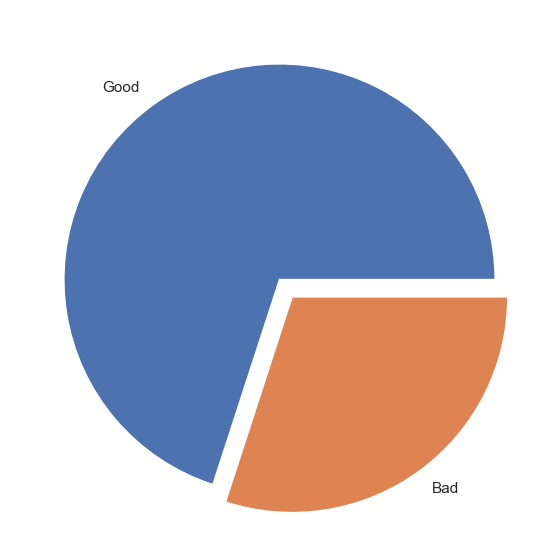

In [445]:
fig, ax = plt.subplots(figsize=(7, 7))
labels = ['Good', 'Bad']
text = f'Total:\n{data.shape[0]}'
print('Target class balance: {}'.format(str(data['risk'].value_counts()[0]) + '/' + str(data['risk'].value_counts()[1])))

plt.pie(data['risk'].value_counts(), labels=labels, explode=[0, 0.1])

Sex class balance: 690/310


([<matplotlib.patches.Wedge at 0x1ea433eb070>,
 [Text(-0.6182917088228987, 0.90978863633311, 'Male'),
  Text(0.6745000459886166, -0.9924966941815747, 'Female')])

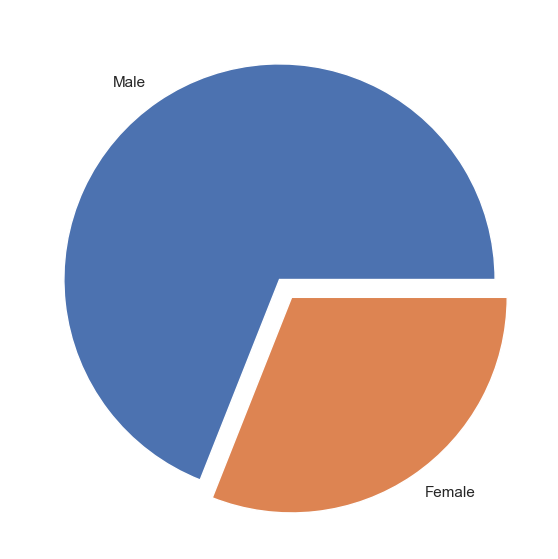

In [446]:
fig, ax = plt.subplots(figsize=(7, 7))
labels = ['Male', 'Female']
text = f'Total:\n{data.shape[0]}'
print('Sex class balance: {}'.format(str(data['sex'].value_counts()[0]) + '/' + str(data['sex'].value_counts()[1])))

plt.pie(data['sex'].value_counts(), labels=labels, explode=[0, 0.1])

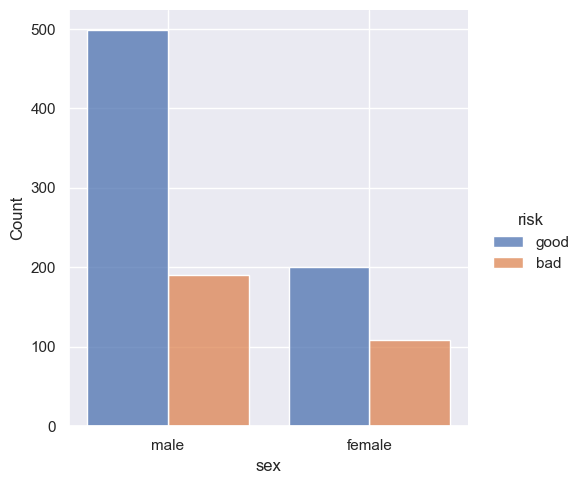

In [447]:
sns.displot(data, x='sex', hue='risk', multiple='dodge', shrink=0.8)

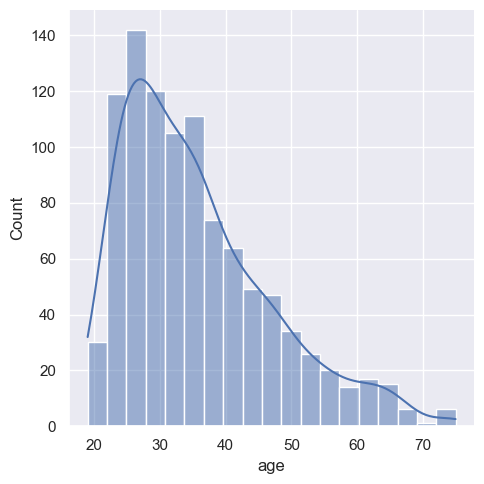

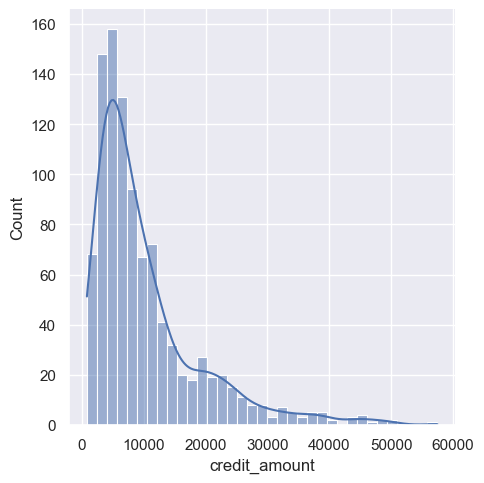

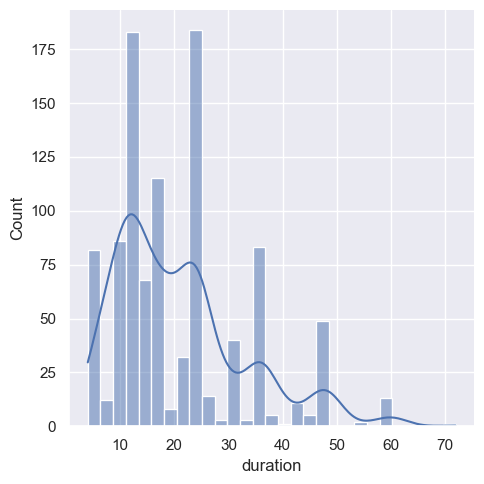

In [448]:
sns.displot(data['age'], kde=True)
sns.displot(data['credit_amount'], kde=True)
sns.displot(data['duration'], kde=True)

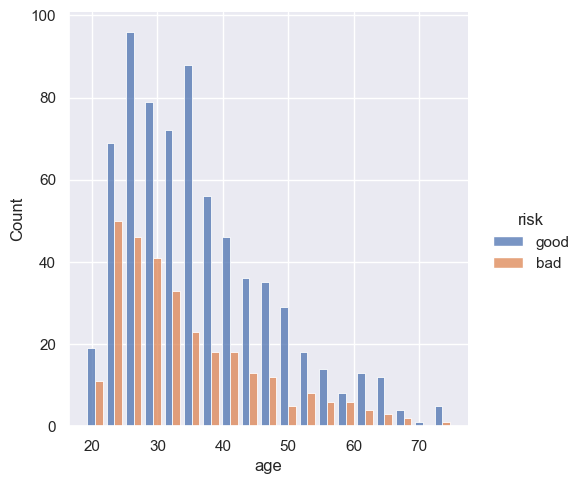

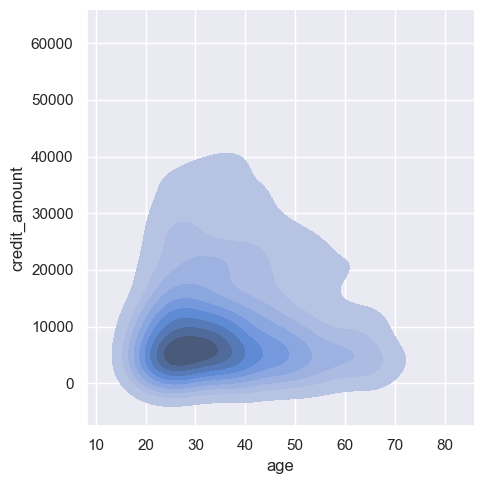

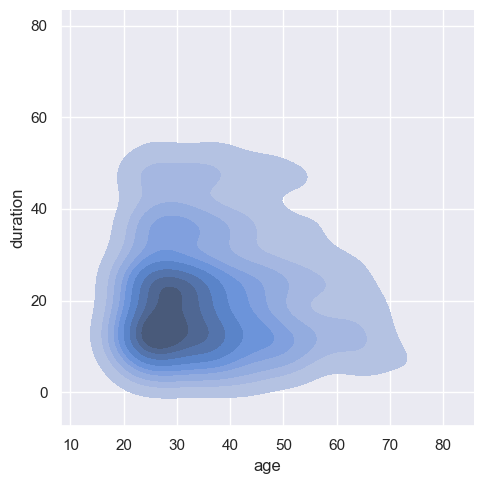

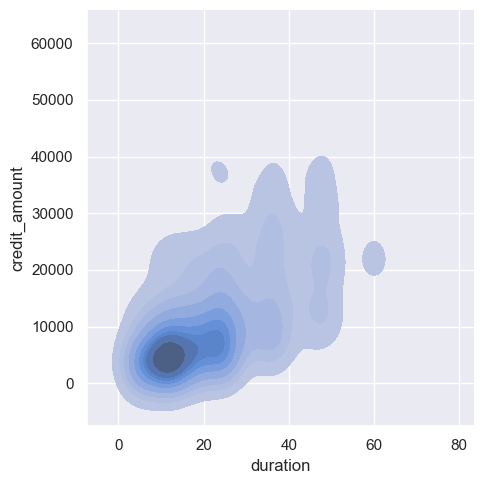

In [449]:
sns.displot(data, x='age', hue='risk', multiple='dodge', shrink=0.8)

sns.displot(data, x='age', y='credit_amount', kind='kde', fill=True)
sns.displot(data, x='age', y='duration', kind='kde', fill=True)
sns.displot(data, x='duration', y='credit_amount', kind='kde', fill=True)

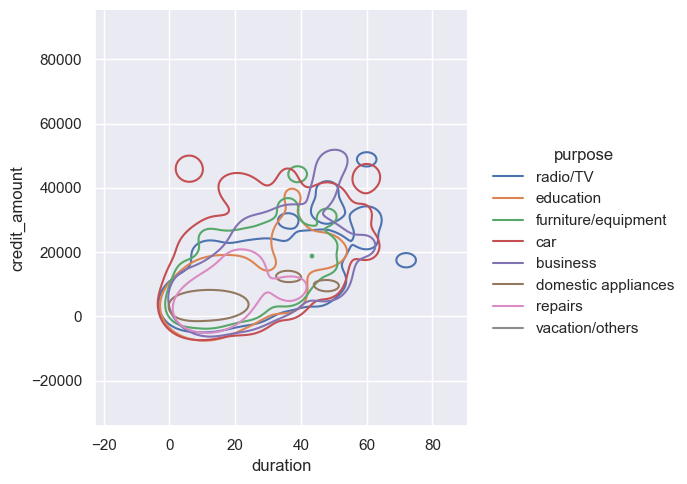

In [450]:
sns.displot(data, x='duration', y='credit_amount', hue='purpose', kind='kde', levels=1)

<Axes: xlabel='purpose', ylabel='credit_amount'>

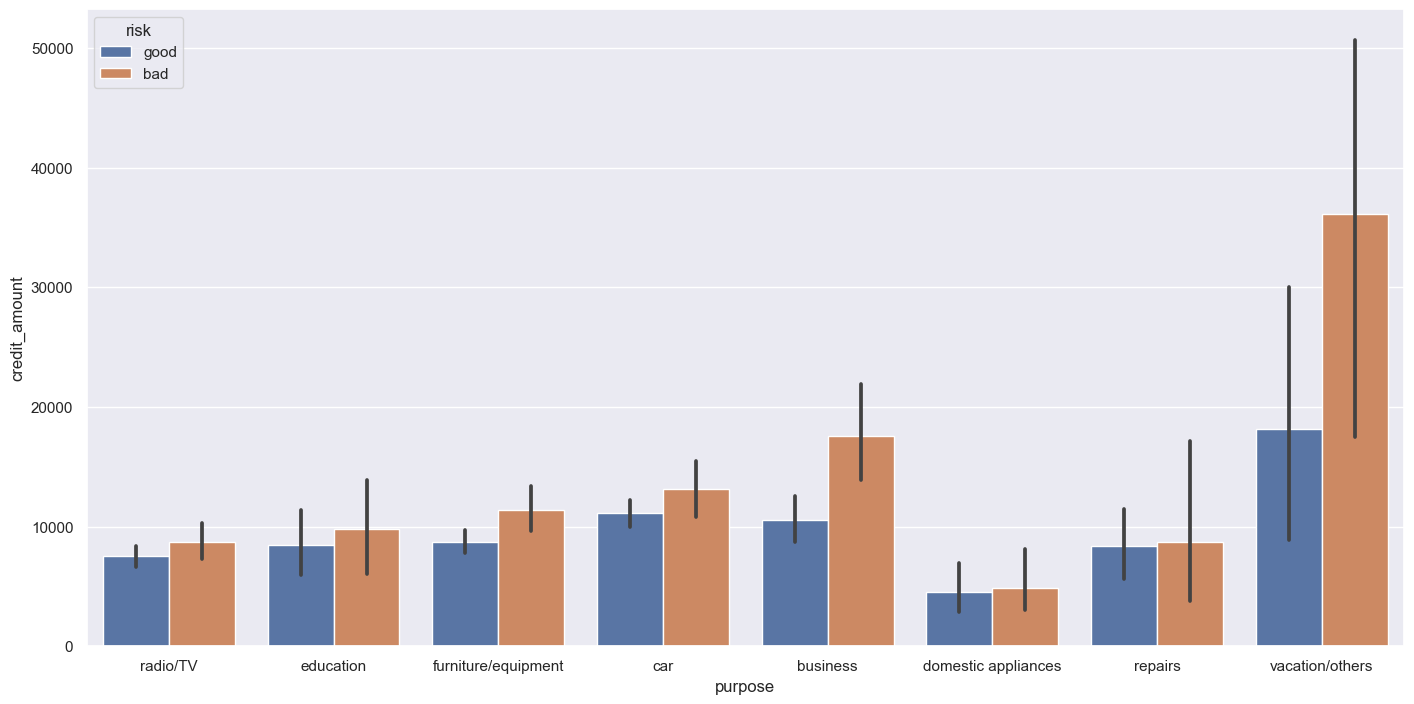

In [451]:
sns.barplot(data, x='purpose', y='credit_amount', hue='risk')

In [452]:
data['sex'] = pd.get_dummies(data['sex']).drop(columns='male').rename(columns={'female': 'sex'}).astype('int64')
data['risk'] = pd.get_dummies(data['risk']).drop(columns='good').rename(columns={'bad': 'risk'}).astype('int64')
data

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk
0,67,0,2,own,NaN,little,3648.22689,6,radio/TV,0
1,22,1,2,own,little,moderate,18571.94031,48,radio/TV,1
2,49,0,1,own,little,NaN,6541.21776,12,education,0
3,45,0,2,free,little,little,24598.22442,42,furniture/equipment,0
4,53,0,2,free,little,little,15198.34470,24,car,1
...,...,...,...,...,...,...,...,...,...,...
995,31,1,1,own,little,NaN,5417.72616,12,furniture/equipment,0
996,40,0,3,own,little,little,12036.96417,30,car,0
997,38,0,2,own,little,NaN,2509.13124,12,radio/TV,0
998,23,0,2,free,little,little,5757.89445,45,radio/TV,1


## Filling NAs

In [453]:
data.isna().sum()

age                   0
sex                   0
job                   0
housing               0
saving_accounts     183
checking_account    394
credit_amount         0
duration              0
purpose               0
risk                  0
dtype: int64

In [454]:
data['checking_account'].value_counts()

checking_account
little      274
moderate    269
rich         63
Name: count, dtype: int64

In [455]:
data['saving_accounts'].value_counts()

saving_accounts
little        603
moderate      103
quite rich     63
rich           48
Name: count, dtype: int64

In [456]:
# Don't actually need right now 
# data = data.fillna('unknown')
# data

## Job from ordinal to dummy encoding

In [457]:
data = pd.concat([data,
           pd.get_dummies(data['job'],  dtype='int64').rename(columns={0: 'job_unskilled_non_resident', 
                                    1: 'job_unskilled_and_resident',
                                    2: 'job_skilled',
                                    3: 'job_highly_skilled'})
], axis=1).drop(columns=['job'])

data

,age,sex,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk,job_unskilled_non_resident,job_unskilled_and_resident,job_skilled,job_highly_skilled
0,67,0,own,NaN,little,3648.22689,6,radio/TV,0,0,0,1,0
1,22,1,own,little,moderate,18571.94031,48,radio/TV,1,0,0,1,0
2,49,0,own,little,NaN,6541.21776,12,education,0,0,1,0,0
3,45,0,free,little,little,24598.22442,42,furniture/equipment,0,0,0,1,0
4,53,0,free,little,little,15198.34470,24,car,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,1,own,little,NaN,5417.72616,12,furniture/equipment,0,0,1,0,0
996,40,0,own,little,little,12036.96417,30,car,0,0,0,0,1
997,38,0,own,little,NaN,2509.13124,12,radio/TV,0,0,0,1,0
998,23,0,free,little,little,5757.89445,45,radio/TV,1,0,0,1,0


## Categorical encoding

In [458]:
pd.get_dummies(data).shape

(1000, 27)

In [459]:
data = pd.get_dummies(data)
data

,age,sex,credit_amount,duration,risk,job_unskilled_non_resident,job_unskilled_and_resident,job_skilled,job_highly_skilled,housing_free,...,checking_account_moderate,checking_account_rich,purpose_business,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others
0,67,0,3648.22689,6,0,0,0,1,0,False,...,False,False,False,False,False,False,False,True,False,False
1,22,1,18571.94031,48,1,0,0,1,0,False,...,True,False,False,False,False,False,False,True,False,False
2,49,0,6541.21776,12,0,0,1,0,0,False,...,False,False,False,False,False,True,False,False,False,False
3,45,0,24598.22442,42,0,0,0,1,0,True,...,False,False,False,False,False,False,True,False,False,False
4,53,0,15198.34470,24,1,0,0,1,0,True,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,1,5417.72616,12,0,0,1,0,0,False,...,False,False,False,False,False,False,True,False,False,False
996,40,0,12036.96417,30,0,0,0,0,1,False,...,False,False,False,True,False,False,False,False,False,False
997,38,0,2509.13124,12,0,0,0,1,0,False,...,False,False,False,False,False,False,False,True,False,False
998,23,0,5757.89445,45,1,0,0,1,0,True,...,False,False,False,False,False,False,False,True,False,False


In [460]:
data.isna().sum()

age                            0
sex                            0
credit_amount                  0
duration                       0
risk                           0
job_unskilled_non_resident     0
job_unskilled_and_resident     0
job_skilled                    0
job_highly_skilled             0
housing_free                   0
housing_own                    0
housing_rent                   0
saving_accounts_little         0
saving_accounts_moderate       0
saving_accounts_quite rich     0
saving_accounts_rich           0
checking_account_little        0
checking_account_moderate      0
checking_account_rich          0
purpose_business               0
purpose_car                    0
purpose_domestic appliances    0
purpose_education              0
purpose_furniture/equipment    0
purpose_radio/TV               0
purpose_repairs                0
purpose_vacation/others        0
dtype: int64

In [461]:
data = data.replace({True: 1, False: 0})
data

,age,sex,credit_amount,duration,risk,job_unskilled_non_resident,job_unskilled_and_resident,job_skilled,job_highly_skilled,housing_free,...,checking_account_moderate,checking_account_rich,purpose_business,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others
0,67,0,3648.22689,6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,22,1,18571.94031,48,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,49,0,6541.21776,12,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,45,0,24598.22442,42,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
4,53,0,15198.34470,24,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,1,5417.72616,12,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
996,40,0,12036.96417,30,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
997,38,0,2509.13124,12,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
998,23,0,5757.89445,45,1,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0


In [462]:
data.dtypes

age                              int64
sex                              int64
credit_amount                  float64
duration                         int64
risk                             int64
job_unskilled_non_resident       int64
job_unskilled_and_resident       int64
job_skilled                      int64
job_highly_skilled               int64
housing_free                     int64
housing_own                      int64
housing_rent                     int64
saving_accounts_little           int64
saving_accounts_moderate         int64
saving_accounts_quite rich       int64
saving_accounts_rich             int64
checking_account_little          int64
checking_account_moderate        int64
checking_account_rich            int64
purpose_business                 int64
purpose_car                      int64
purpose_domestic appliances      int64
purpose_education                int64
purpose_furniture/equipment      int64
purpose_radio/TV                 int64
purpose_repairs          

<Axes: >

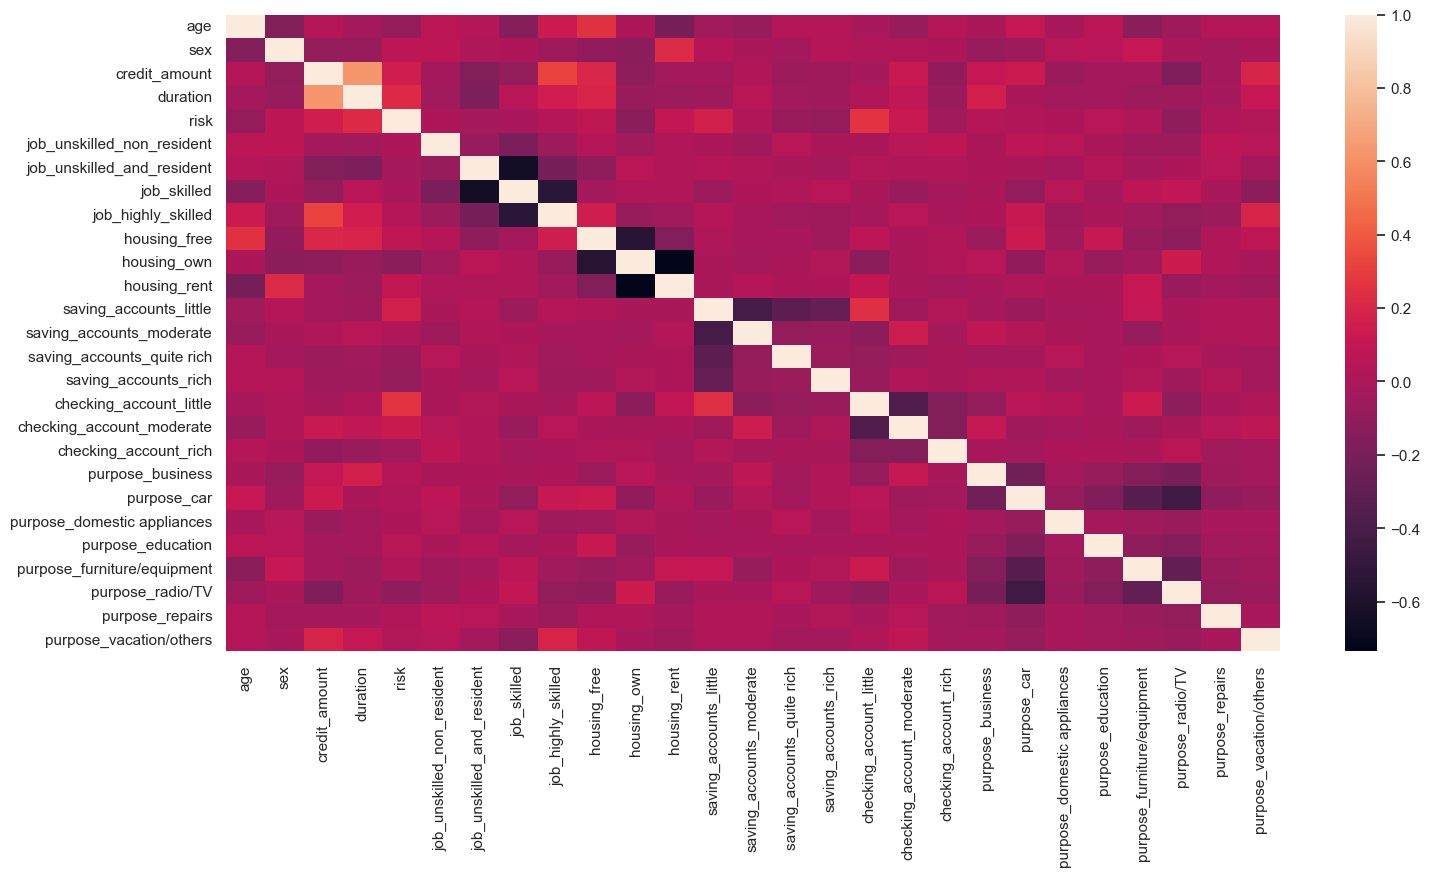

In [463]:
sns.heatmap(data.corr())

In [464]:
data.columns = [col.lower().strip().replace(' ', '_').replace('/', '_') for col in data.columns]
data.corr()['risk'].sort_values()

housing_own                   -0.134589
purpose_radio_tv              -0.106922
age                           -0.091127
saving_accounts_rich          -0.085749
saving_accounts_quite_rich    -0.070954
checking_account_rich         -0.044009
job_unskilled_and_resident    -0.021822
job_skilled                   -0.013559
job_unskilled_non_resident     0.005951
purpose_domestic_appliances    0.008016
purpose_repairs                0.020828
purpose_furniture_equipment    0.020971
saving_accounts_moderate       0.022255
purpose_car                    0.022621
purpose_vacation_others        0.028058
purpose_business               0.036129
job_highly_skilled             0.040559
purpose_education              0.049085
sex                            0.075493
housing_free                   0.081556
housing_rent                   0.092785
checking_account_moderate      0.119581
credit_amount                  0.154739
saving_accounts_little         0.161007
duration                       0.214927


## Pipeline
I will use one of my standard pipelines for logistic regression in sake of simplicity.  
Although Grid search could be performed, in my opinion, it is excessive for this case.

In [468]:
X = data.drop(columns='risk')
y = data['risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

print('''
X_train shape:\t{}
y_train shape:\t{}
X_test shape:\t{}
y_train shape:\t{}
'''.format(X_train.shape,
           y_train.shape,
           X_test.shape,
           y_test.shape))

y_test


X_train shape:	(900, 26)
y_train shape:	(900,)
X_test shape:	(100, 26)
y_train shape:	(100,)



379    0
353    1
933    0
947    0
115    0
      ..
229    0
506    0
21     0
799    0
803    0
Name: risk, Length: 100, dtype: int64

Fitting 5 folds for each of 15360 candidates, totalling 76800 fits
fitted
Best parameter (CV score=0.739):
{'classifier__C': 0.046415888336127774, 'classifier__fit_intercept': True, 'classifier__max_iter': 100, 'classifier__solver': 'lbfgs', 'pca__n_components': 25, 'pca__svd_solver': 'auto', 'pca__whiten': True, 'scaler__with_mean': True, 'scaler__with_std': True}
PREDICTIONS ON TEST:
              precision    recall  f1-score   support

           0       0.89      0.61      0.72       140
           1       0.48      0.83      0.61        60

    accuracy                           0.68       200
   macro avg       0.69      0.72      0.66       200
weighted avg       0.77      0.68      0.69       200

Predicted classes:
	{0: 95, 1: 105}

Gini: 
	0.4404761904761907


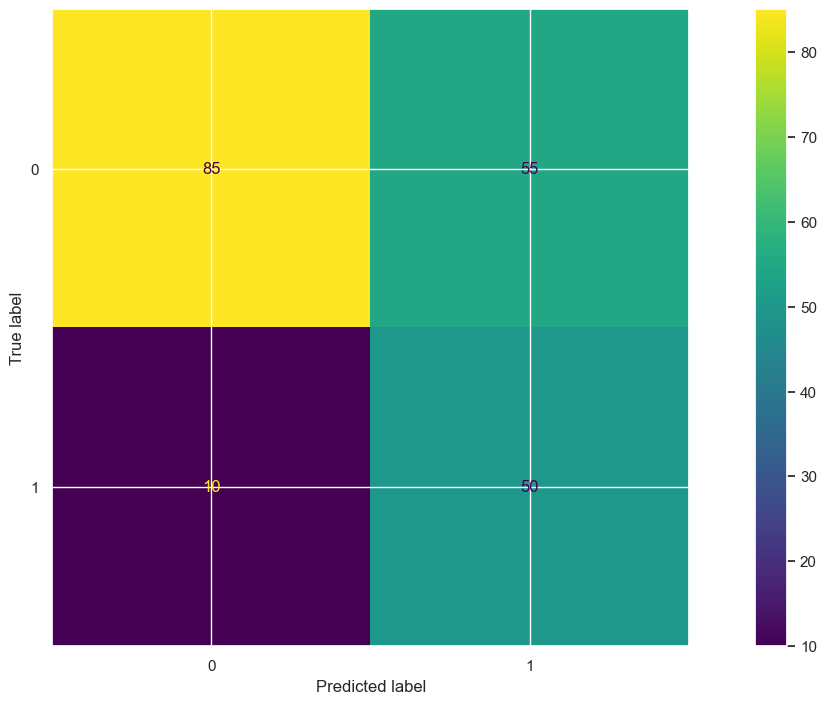

In [521]:
def gini(true, pred_proba):
    return 2*roc_auc_score(true, pred_proba)-1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
pca = PCA()
classifier = LogisticRegression()

pipeline = Pipeline([
                    ('scaler', scaler),
                     ('pca', pca),
                     ('classifier', classifier)
                     ])


param_grid = {
    'scaler__with_mean': [True, False],
    'scaler__with_std': [True, False],
    'pca__n_components': [1, 2, 3, 5, 10, 15, 20, 25],
    'pca__whiten': [False, True],
    'pca__svd_solver': ['auto', 'full'],
    # 'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
    'classifier__C': np.logspace(-4, 4, 4),
    'classifier__fit_intercept': [True, False],
    'classifier__solver': ['lbfgs', 'liblinear',  'newton-cholesky'],
    'classifier__max_iter': [100, 150, 250, 500, 1000]
}

search = GridSearchCV(pipeline, param_grid, verbose=1, n_jobs=-1, refit=True)

search.fit(X_train, y_train)

print('fitted')
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

THRESHOLD = 0.25

# y_pred = pipeline.predict(X_test)
y_pred_proba = search.predict_proba(X_test)
y_pred = np.where(y_pred_proba[:,1] > THRESHOLD, 1, 0)


print('PREDICTIONS ON TEST:')
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
print('Predicted classes:\n\t{}\n'.format(dict(zip(*np.unique(y_pred, return_counts=True)))))
ConfusionMatrixDisplay(cm).plot()
print('Gini: \n\t{}'.format(gini(y_test, y_pred)))

In [512]:
baseline_scaler = StandardScaler()
baseline_PCA = PCA()
baseline_logreg = LogisticRegression()


baseline_logreg.fit(X_train, y_train)
y_pred_proba = baseline_logreg.predict_proba(X_test)
y_pred = np.where(y_pred_proba[:,1] > THRESHOLD, 1, 0)
print('Gini logreg: \n\t{}'.format(gini(y_test, y_pred)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
baseline_scaler.fit_transform(X_train, y_train)

baseline_logreg.fit(X_train, y_train)
y_pred_proba = baseline_logreg.predict_proba(X_test)
y_pred = np.where(y_pred_proba[:,1] > THRESHOLD, 1, 0)
print('Gini Scaler+logreg: \n\t{}'.format(gini(y_test, y_pred)))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

baseline_PCA.fit_transform(X_train, y_train)
baseline_logreg.fit(X_train, y_train)
y_pred_proba = baseline_logreg.predict_proba(X_test)
y_pred = np.where(y_pred_proba[:,1] > THRESHOLD, 1, 0)
print('Gini PCA+logreg: \n\t{}'.format(gini(y_test, y_pred)))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
baseline_scaler.fit_transform(X_train, y_train)
baseline_PCA.fit_transform(X_train, y_train)
baseline_logreg.fit(X_train, y_train)
y_pred_proba = baseline_logreg.predict_proba(X_test)
y_pred = np.where(y_pred_proba[:,1] > THRESHOLD, 1, 0)
print('Gini Scaler+PCA+logreg: \n\t{}'.format(gini(y_test, y_pred)))

Gini logreg: 
	0.3761904761904762
Gini Scaler+logreg: 
	0.3761904761904762
Gini PCA+logreg: 
	0.3761904761904762
Gini Scaler+PCA+logreg: 
	0.3761904761904762


PREDICTIONS ON TEST:
              precision    recall  f1-score   support

           0       0.86      0.64      0.73       140
           1       0.47      0.77      0.59        60

    accuracy                           0.68       200
   macro avg       0.67      0.70      0.66       200
weighted avg       0.75      0.68      0.69       200

Predicted classes:
	{0: 103, 1: 97}

Gini: 
	0.4023809523809523


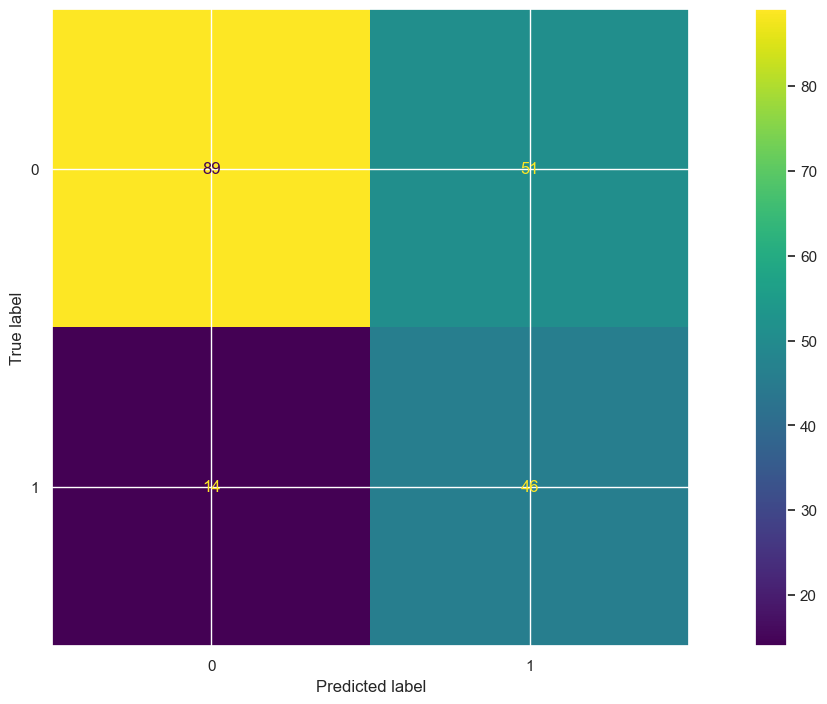

In [523]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

pipeline.fit(X_train, y_train)

y_pred_proba = pipeline.predict_proba(X_test)
y_pred = np.where(y_pred_proba[:,1] > THRESHOLD, 1, 0)


print('PREDICTIONS ON TEST:')
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
print('Predicted classes:\n\t{}\n'.format(dict(zip(*np.unique(y_pred, return_counts=True)))))
ConfusionMatrixDisplay(cm).plot()
print('Gini: \n\t{}'.format(gini(y_test, y_pred)))

In [515]:
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('pca', PCA()),
  ('classifier', LogisticRegression())],
 'verbose': False,
 'scaler': StandardScaler(),
 'pca': PCA(),
 'classifier': LogisticRegression(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': None,
 'pca__n_oversamples': 10,
 'pca__power_iteration_normalizer': 'auto',
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'classifier__C': 1.0,
 'classifier__class_weight': None,
 'classifier__dual': False,
 'classifier__fit_intercept': True,
 'classifier__intercept_scaling': 1,
 'classifier__l1_ratio': None,
 'classifier__max_iter': 100,
 'classifier__multi_class': 'auto',
 'classifier__n_jobs': None,
 'classifier__penalty': 'l2',
 'classifier__random_state': None,
 'classifier__solver': 'lbfgs',
 'classifier__tol': 0.0001,
 'classifier__verbose': 0,
 'classifier__warm_s